# Identifying and describing spatial communities with spatial statistics

*TL;DR we provide an overview of spatial data analysis methods for the analysis of spatial omics data*

## Background
When dealing with spatial omics dataset, we might be interested in identifying *spatial patterns* in the data, that is, identifying features that vary in *space*. 
**Spatial statistics** {cite}`gelfand2010handbook` are quantitative scores that can be used to identify spatial patterns in the tissue.
Here, we'll take a look at various spatial statistics implemented in Squidpy {cite}`Palla2022` with a different set of spatial omics data.

## Datasets
We'll be using 2 datasets for this section. They can be easily downloaded with Squidpy. Let's initialize the variables and take a quick look at the data.

### Mibitof
This dataset consists of 3 tissue slides from 2 donors and 8 cell types. The dataset was originally published by {cite}`Hartmann2020` and was pre-processed in Squidpy.

In [1]:
import squidpy as sq
import scanpy as sc

sc.set_figure_params(figsize=(5, 5))

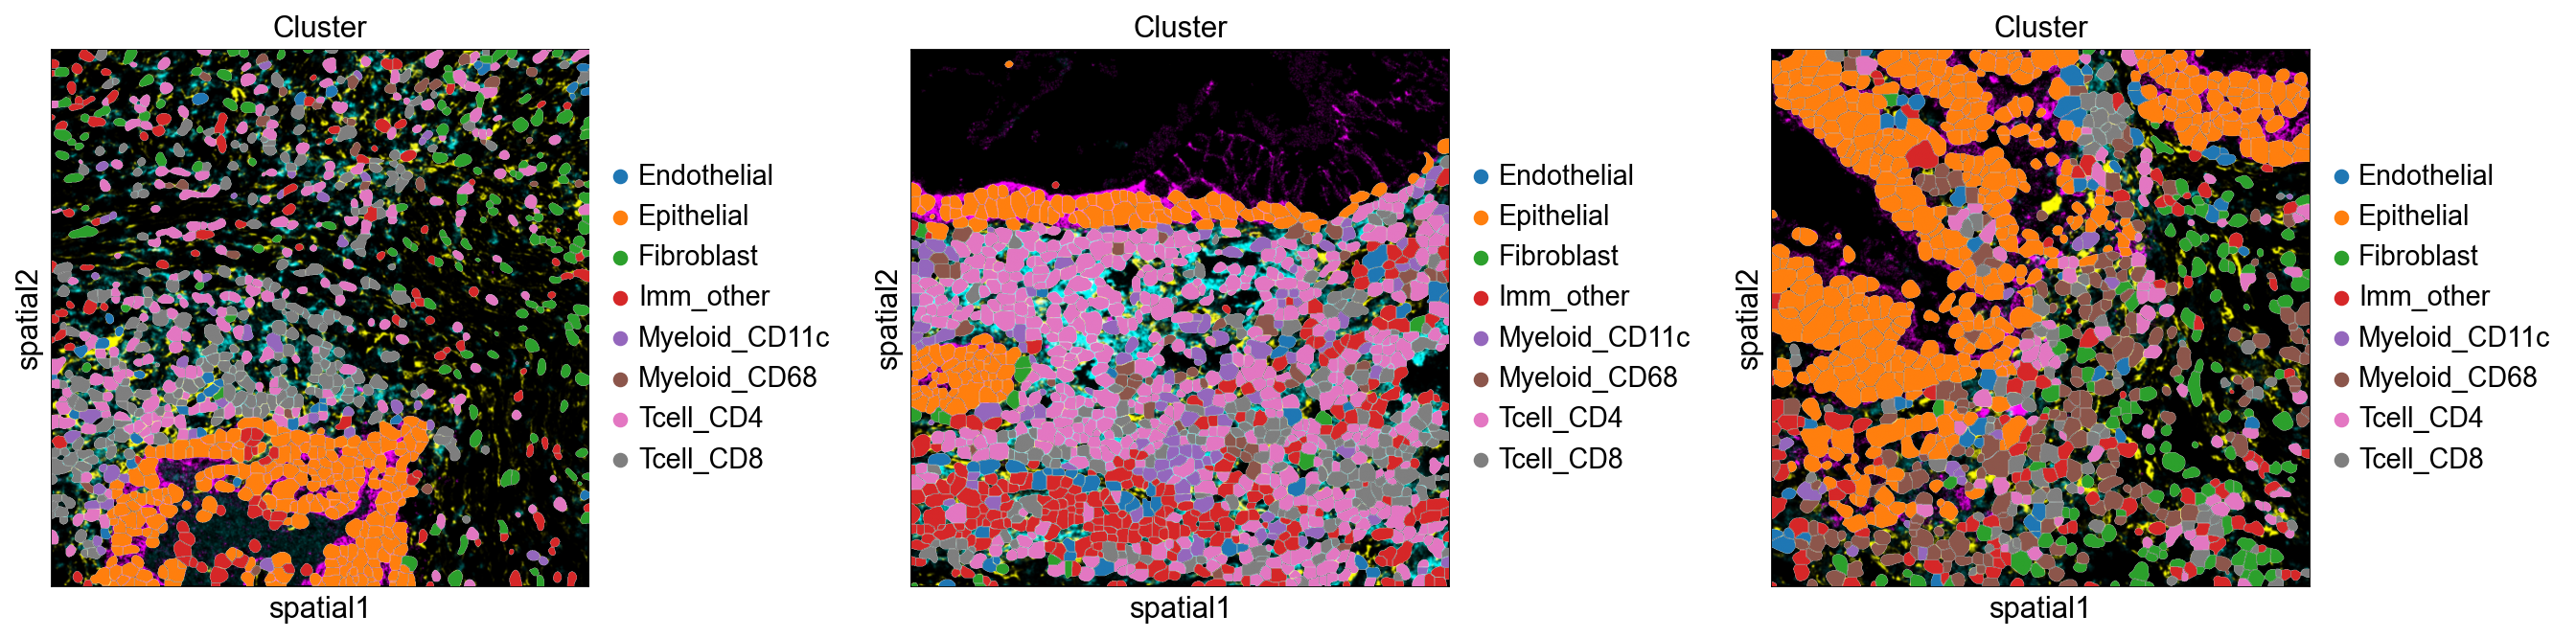

In [2]:
mibitof = sq.datasets.mibitof()
sq.pl.spatial_segment(
    mibitof,
    library_key="library_id",
    color="Cluster",
    seg_cell_id="cell_id",
    wspace=0.3,
)

### Visium
This dataset consists of 1 tissue slides from 1 mouse. The dataset was originally published in [CITE] and was pre-processed in Squidpy.

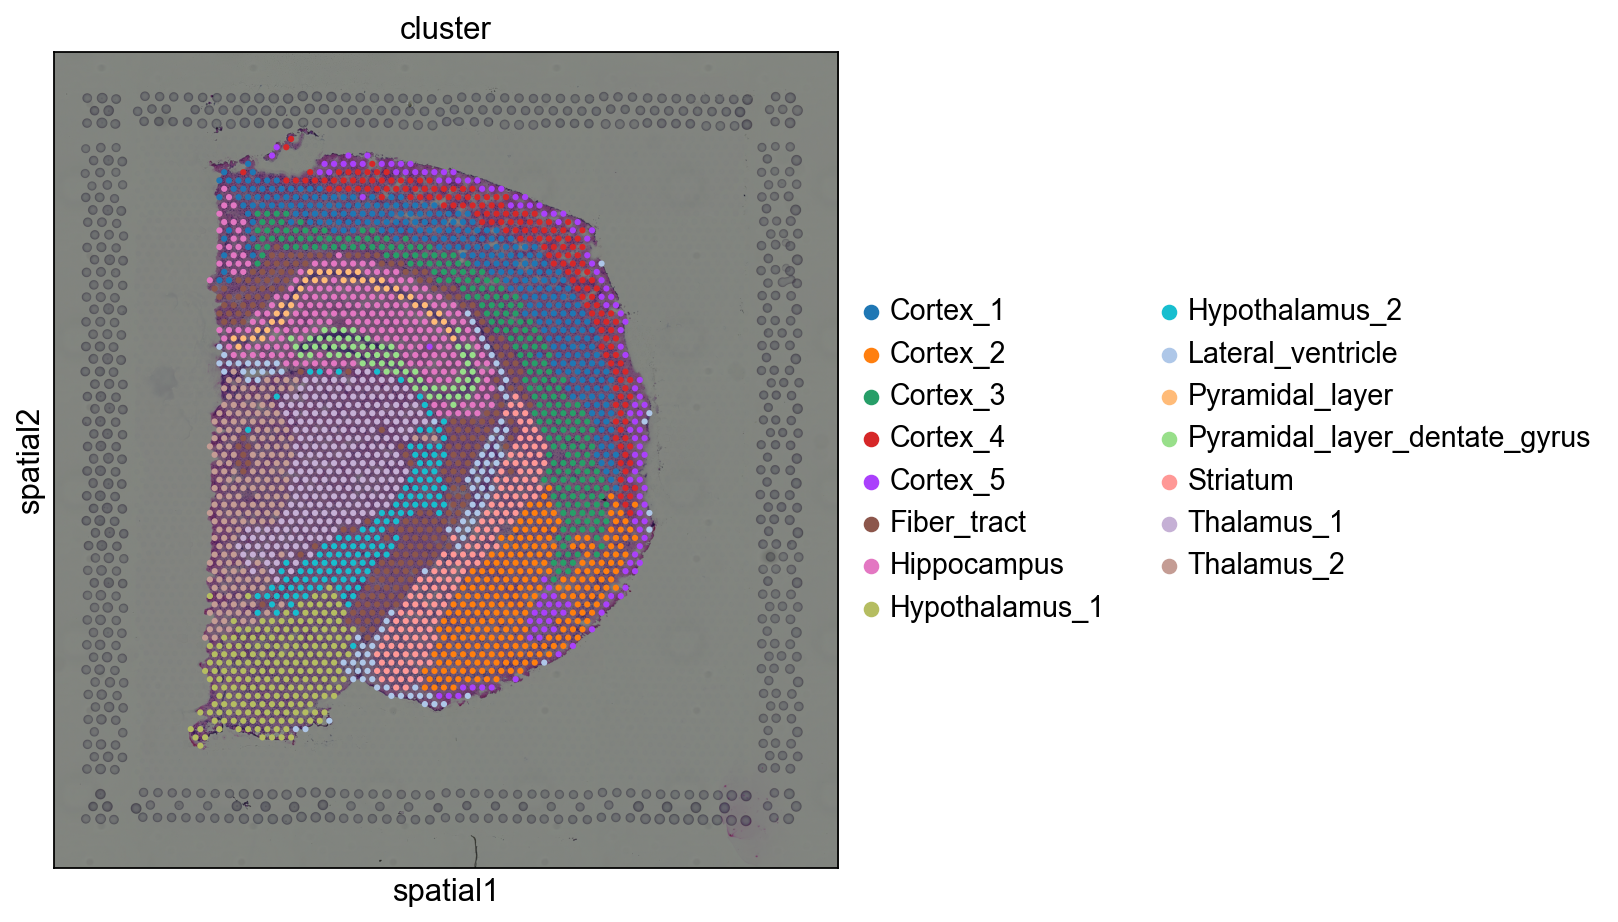

In [3]:
visium = sq.datasets.visium_hne_adata()
sq.pl.spatial_scatter(visium, color="cluster", figsize=(10, 10))

## Identifying spatial domains
Spatial omics data entails not only the usual cell x gene matrix but, but additionally orthogonal information that we can use to describe and predict features of interest from the data, such as the tissue image and the spatial coordinates. 

The identification of cell types or states is one of the first data analysis tasks, as it allows to formulate key hypothesis from the data. This is usually performed by clustering the data based on some type of similarity between data points in feature space. One of the most popular approaches for this task is to compute a nearest neighbor graph on a (low dimensional) representation of the data and then perform community detection on such graph. 
In the case of spatial omics data, such approach can be easily extended to account for the similarity in coordinate space (and not only feature space) of the data. Because of including both gene and spatial similarity in the way we perform the cluster identification, we can call this task "identification of spatial domains". 
In this section, we will illustrate this approach with a pedagogical example using Squidpy, and then point to more advanced algorithm for accomplishing this task.

Let's work with the visium dataset for the purpose of this example. In this case, we will be using the term "spot" referring to observations stored in the rows of the AnnData object.
First off, we want an algorithm that encode similarity between observations in some coordinate space, such as gene expression space and spatial coordinates. A nearest neighbor graph is reliable representation for this task. Let's compute the nearest neighbor graph in spatial coordinates and the nearest neighbor graph in PCA coordinates.

In [4]:
sc.pp.neighbors(visium)
sq.gr.spatial_neighbors(visium)
nn_graph_genes = visium.obsp["connectivities"]
nn_graph_space = visium.obsp["spatial_connectivities"]

Second, we want to identify communities (clusters) in both representations jointly. One straightforward way to do this is by simply adding the two graphs and compute leiden on the joint graph. We can also weight the importance of each graph based on an hyperparameters `alpha`.

In [14]:
alpha = 0.2

joint_graph = (1 - alpha) * nn_graph_genes + alpha * nn_graph_space
sc.tl.leiden(visium, adjacency=joint_graph, key_added="joint_leiden")


Let's visualize the results with Squidpy. The first annotation (`cluster`) is a cluster annotation based only on gene expression similarity.

In [16]:
# visium.uns.pop("joint_leiden_colors")

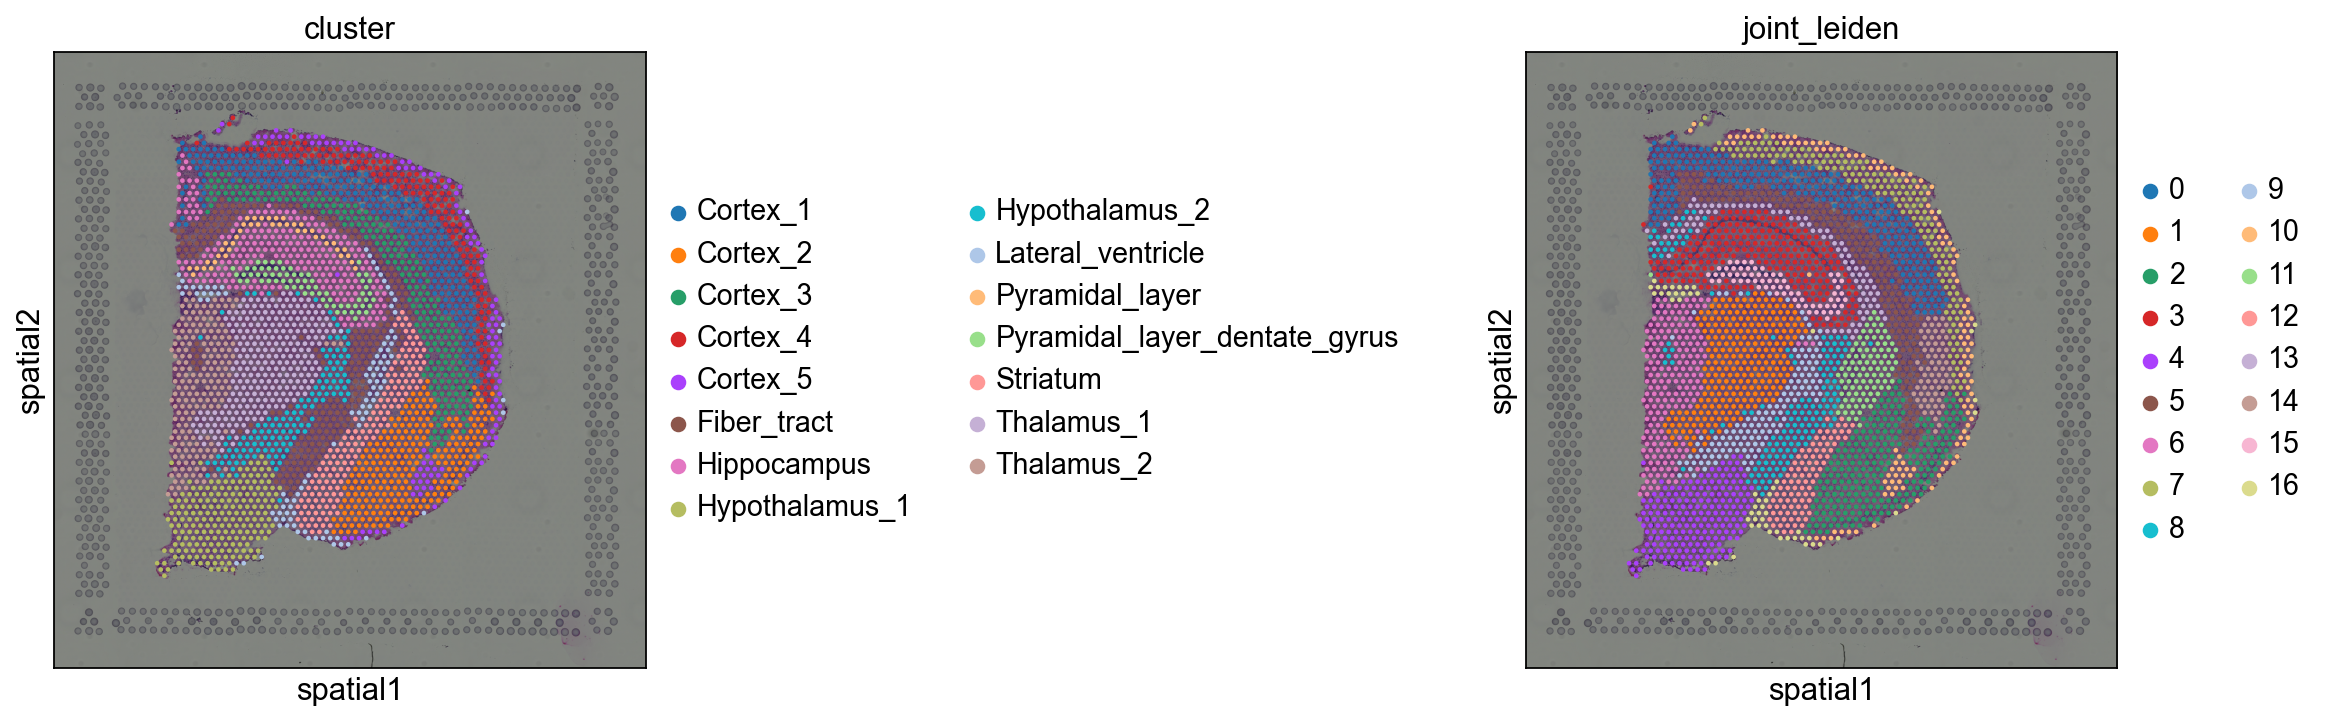

In [20]:
sq.pl.spatial_scatter(visium, color=["cluster", "joint_leiden"], wspace=0.8)

We can see that such approach is essentially "smoothing" the cluster annotations based on spatial distances. This is a purely pedagogical approach and despite it has been used in practice :cite:{Chen2022-oa}, the reader is invited to check out more principled approaches like:
- HMRF :cite:`Dries2021`
- BayesSpace :cite:`Zhao2021-vi`
- SpaGCN :cite:`Hu2021-SpaGCN`

## Identifying interactions between spatial communities
After annotating cell types or cell states in the dataset (or spots, according to the technology at end), we can quantify whether such annotations are spatially enriched. 
To this end, Computing a neighborhood enrichment can help us identify clusters that are neighbors in the tissue of interest. 
In short, it’s an enrichment score on spatial proximity of clusters: if observations (cells or spots) belonging to a cluster are often close to observations belonging to 
another cluster, then they will have a high score and will appear to be enriched. On the other hand, if they are far apart, and therefore are seldom neighbors, the score will be low and they can be defined as depleted.
This score is based on a permutation-based test, and you can set the number of permutations with the n_perms argument (default is 1000).

Since the function works on a spatial connectivity matrix (spatial graph), we need to compute that as well. This can be done with `squidpy.gr.spatial_neighbors()`.

Finally, we’ll directly visualize the results with `squidpy.pl.nhood_enrichment()`.


100%|██████████| 1000/1000 [00:06<00:00, 148.25/s]
/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


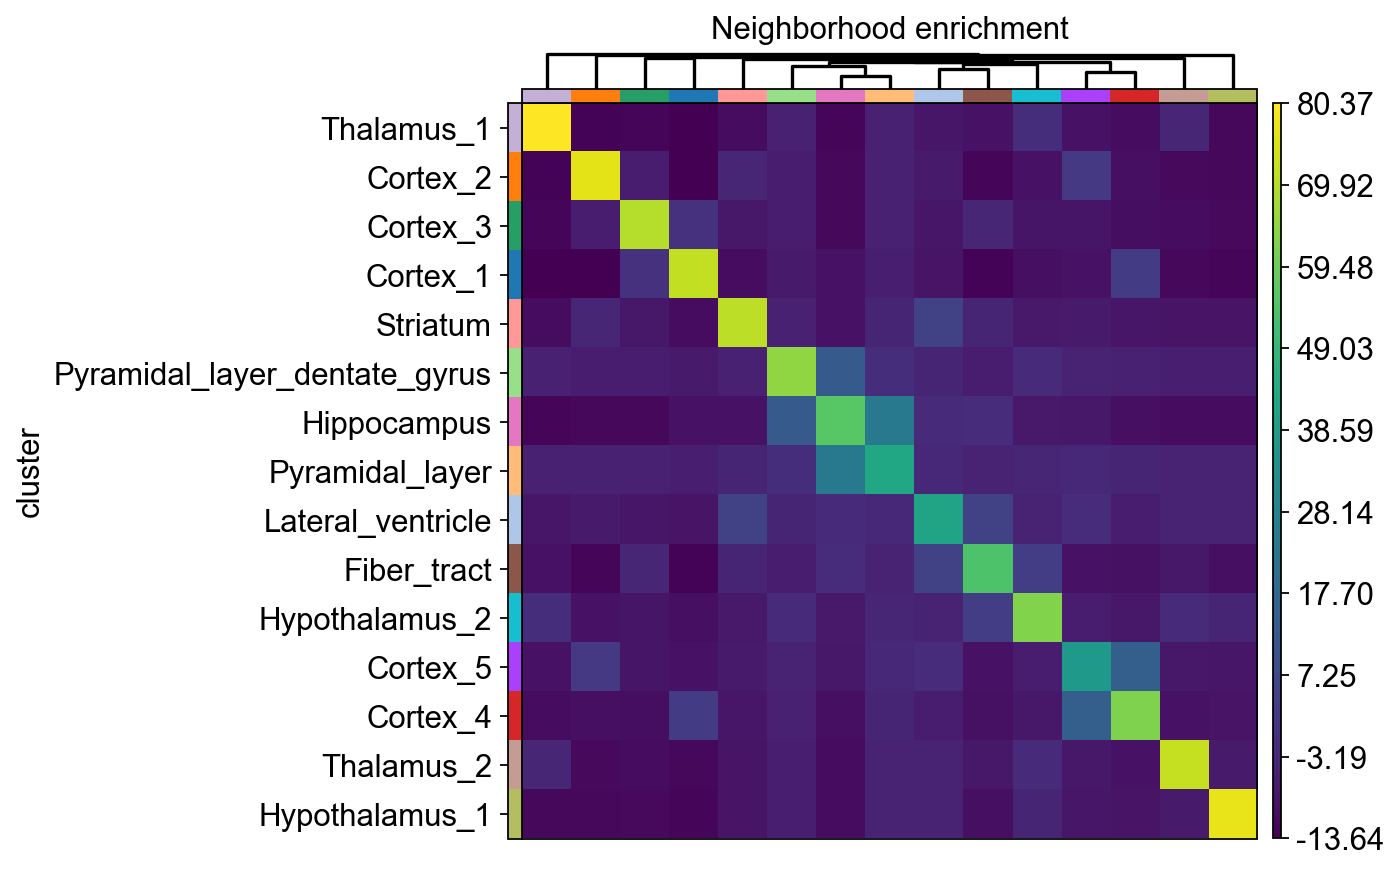

In [33]:
sq.gr.spatial_neighbors(visium)
sq.gr.nhood_enrichment(visium, cluster_key="cluster")
sq.pl.nhood_enrichment(
    visium, cluster_key="cluster", method="average", figsize=(5, 5)
)  # `method` compute the hierarchical clustering dendrogram for the heatmap

From the above plot, we can see that there seems to be an enrichment for clusters of the `Pyramidal_layer` and `Dentate_gyrus`. By looking at the spatial scatterplot above, we can confirm that these clusters are indeed "neighbors" as their members are often close.

Let's perform the same analysis on the `mibitof` dataset. Since this dataset consists of 3 tissue slides, we can perform the analysis jointly on all the three slides together. To achieve this, we can first compute a spatial graph for all 3 slides, and then compute the same function as above.

100%|██████████| 1000/1000 [00:07<00:00, 135.22/s]
/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


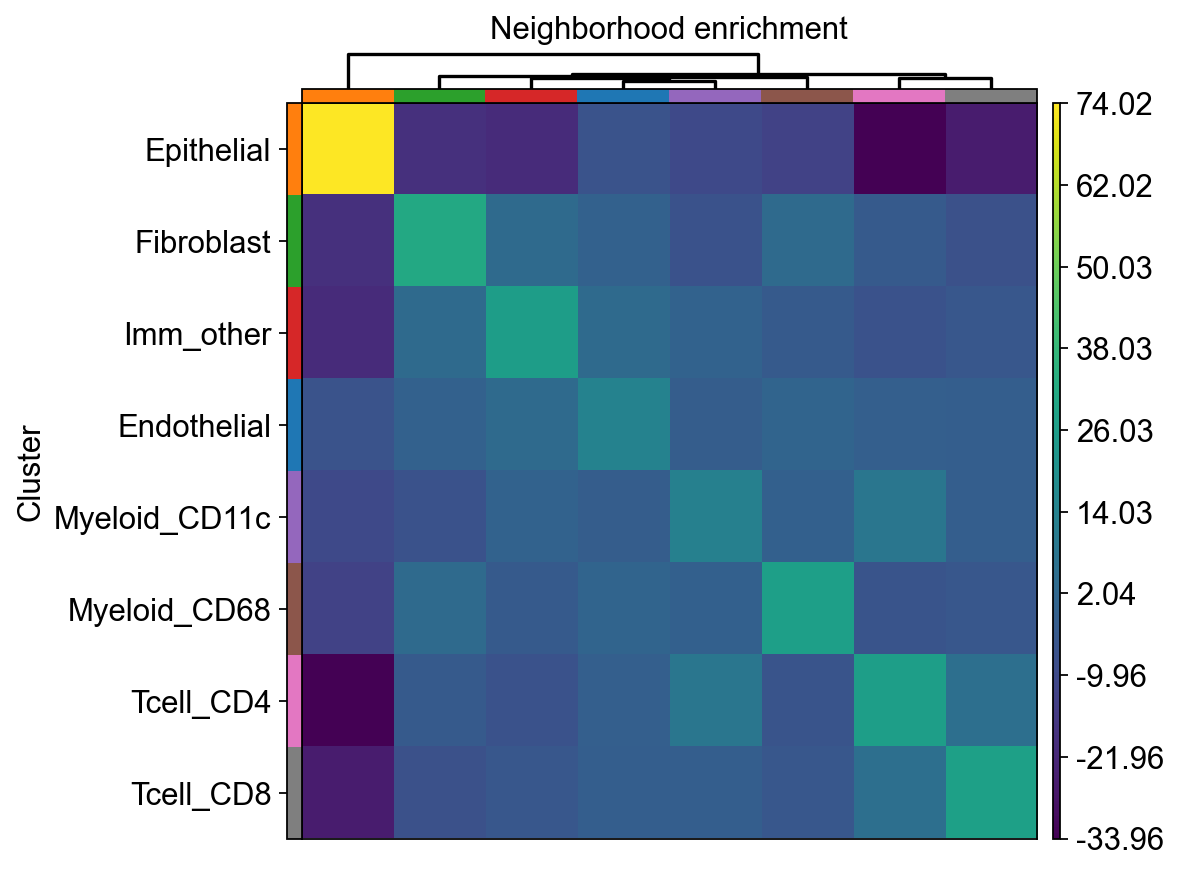

In [32]:
sq.gr.spatial_neighbors(
    mibitof, coord_type="generic", library_key="library_id", delaunay=True
)
sq.gr.nhood_enrichment(mibitof, cluster_key="Cluster")
sq.pl.nhood_enrichment(mibitof, cluster_key="Cluster", method="average")

The cluster `Epithelial` seems to show a strong enrichment with itself, confirming the visual intuition from the segmentation plot above. In contrast, the other clusters do not seem to show a specific enrichment.

A similar approach to such problem is computing what we call an *interaction matrix*, that is, the sum of all connecting observations between clusters in tissue. Such approach is related to the neighborood enrichment analysis yet it is not a test, but should be viewed as a simple summary statistics of the spatial graph.
Let's take a look at how the interaction matrix looks like for the two datasets.

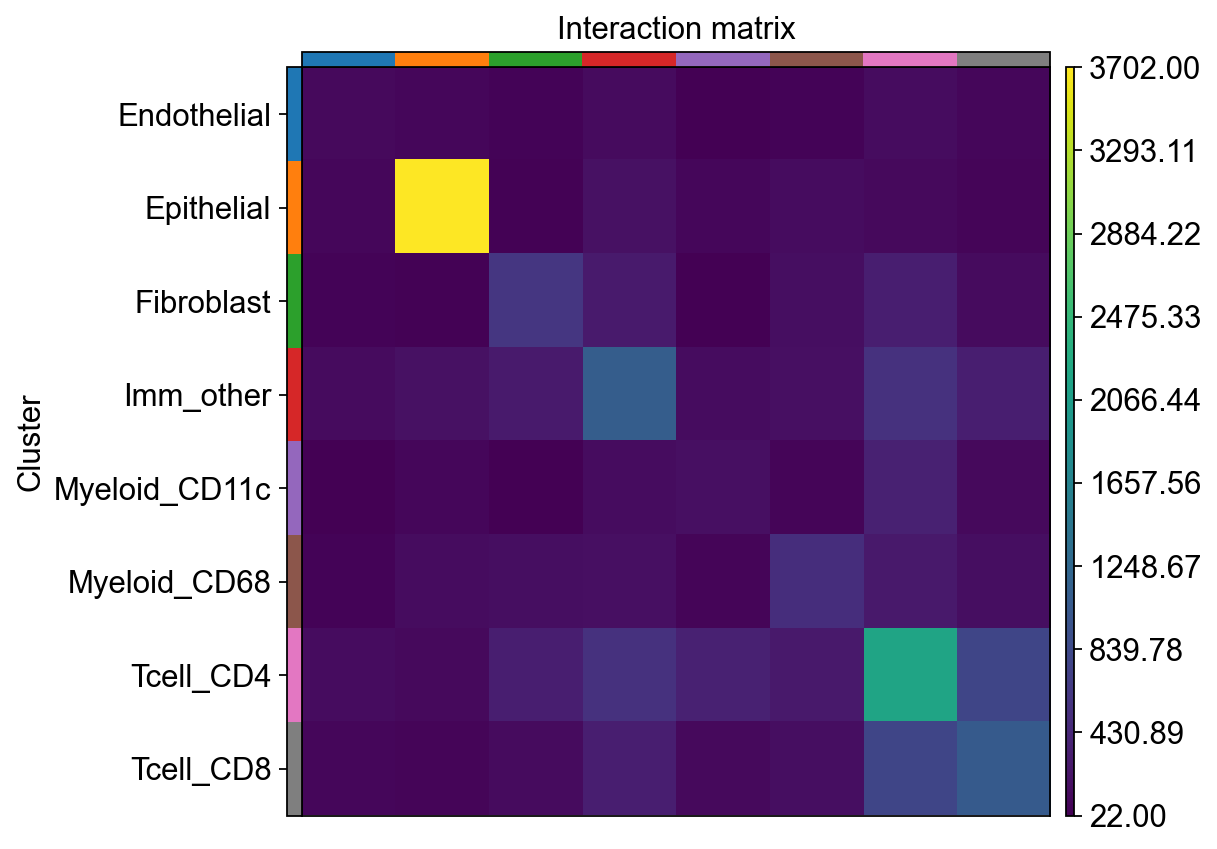

In [38]:
sq.gr.interaction_matrix(mibitof, cluster_key="Cluster")
sq.pl.interaction_matrix(mibitof, cluster_key="Cluster")

For the `mibitof` dataset we can see that, similarly to the neighborhood enrichment test, the `Epithelial` cluster is tightly self connected, and also the T cell clusters `Tcell_CD4` and `Tcell_CD8` also seem to share an high degree of connection.

Let's perform the same analysis for the visium dataset.

/Users/giovanni.palla/miniconda3/envs/squidpy/lib/python3.8/site-packages/squidpy/pl/_utils.py:582: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.hspace'].  Set pad=0 to keep the old behavior.
  col_ax = divider.append_axes("top", size="5%")


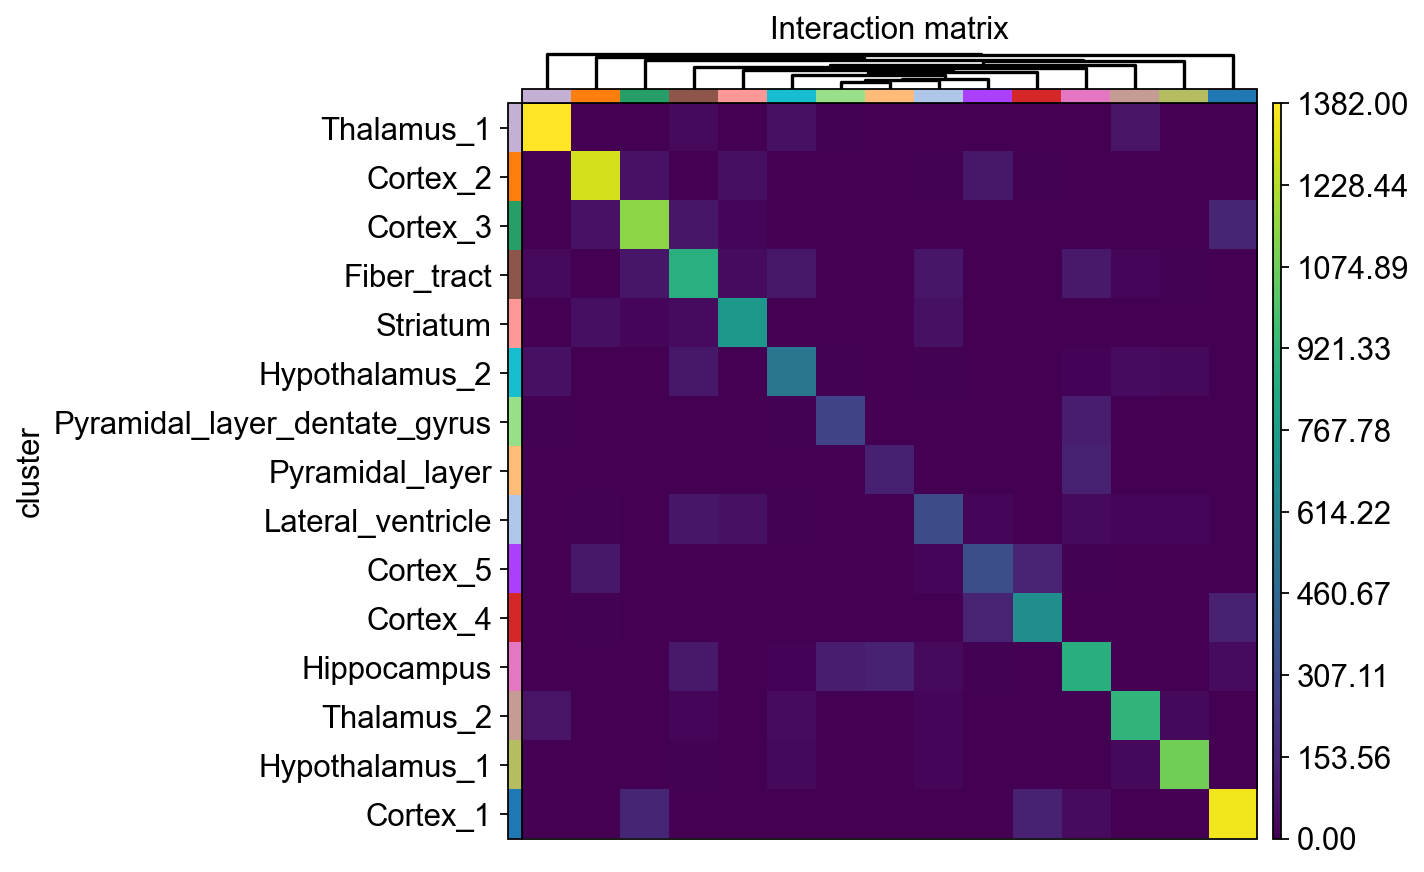

In [40]:
sq.gr.interaction_matrix(visium, cluster_key="cluster")
sq.pl.interaction_matrix(
    visium, cluster_key="cluster", method="average", figsize=(5, 5)
)

For the `visium` dataset instead, we roughly recapitulate the neighborhood enrichment test, yet we seem to not observe a particularly strong interaction between the `Pyramidal_layer` and `Dentate_gyrus` clusters. 
One explanation for such result is that the number of observations of such cluster is low, hence the low number of interactions.

## Co-occurrence across spatial dimensions

Another spatial statistics that can be computed on cell type annotations in spatial coordiantes is what we call the co-occurrence score {cite}`Tosti2021,Palla2022`. The co-occurrence score gives us an indication on whether clusters co-occurr with each other at increasing distances across the tissue.
The co-occurrence score is defined as:

$\frac{p(exp|cond)}{p(exp)}$

where $p(exp|cond)$ is the conditional probability of observing a cluster $exp$ conditioned
on the presence of a cluster $cond$ whereas $exp$ is the probability of observing $exp$
in the radius size of interest. The score is computed across increasing radii size around each observation (i.e. spots here) in the tissue.



100%|██████████| 1/1 [00:06<00:00,  6.95s/]


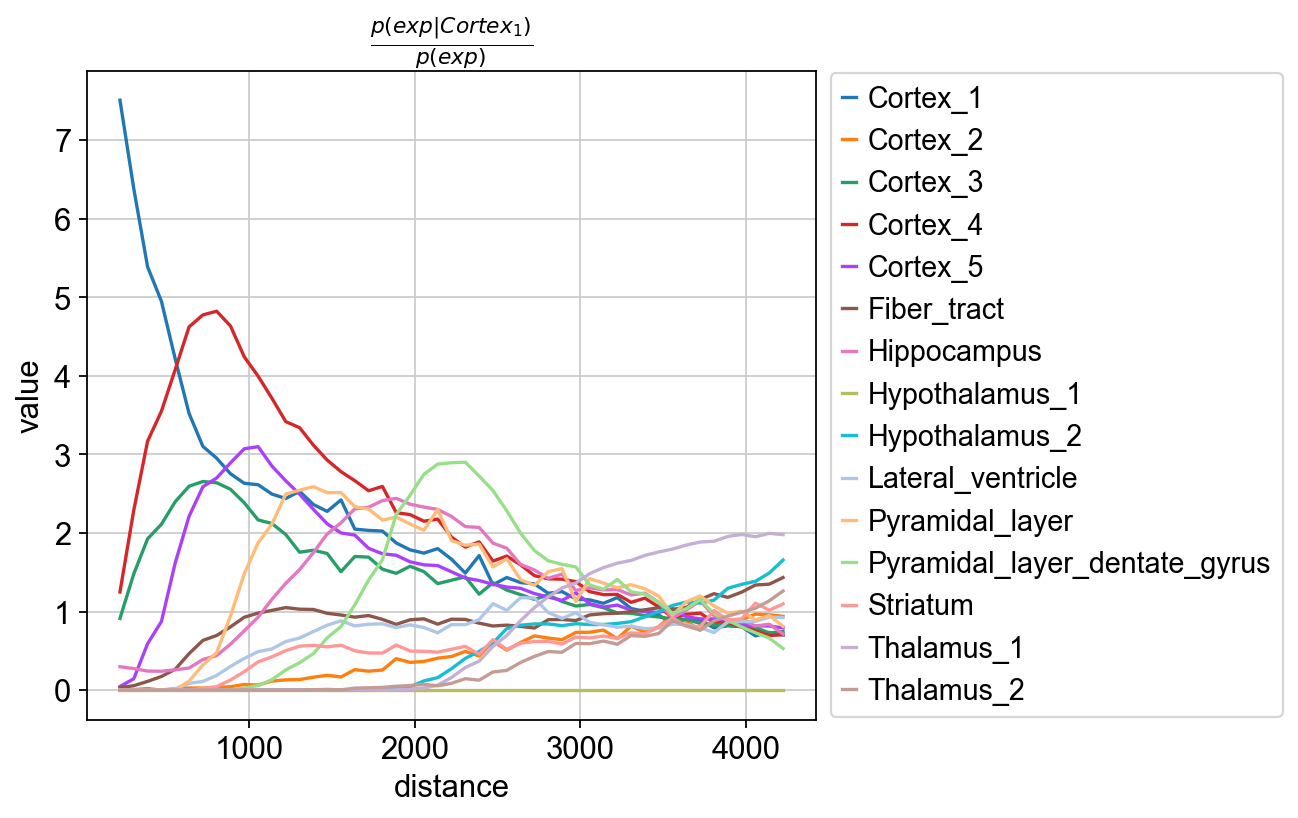

In [47]:
sq.gr.co_occurrence(visium, cluster_key="cluster")
sq.pl.co_occurrence(visium, cluster_key="cluster", clusters="Cortex_1", figsize=(8, 5))

Here, we selected to visualize the cluster `Cortex_1` to visualize how at close distances, the cluster co-occurr with the other `Cortex` clusters, as expected.

## Spatially variable genes
Finally, it can be also of interest to identify patterns at the feature level. In other words, to identify genes (or proteins) that varies in space. Here again, we provide a pedagogical example using Squidpy, but the reader is invited to check out these references for more advanced methods and in-depth clarifications:
- SPARK, for generalize linear spatial models {cite}`Sun2020-da`.
- SpatialDE2, for gaussian process based spatially variable genes identification {cite}`Kats2021-cy`.
- the following [chapter](https://www.huber.embl.de//msmb/Chap-Images.html#sec:spatstat) from MSMB {cite}`Holmes2019-dz`.

One approach for the identification of spatially variable genes is the Moran's I score, a measure of spatial autocorrelation (correlation of signal, such as gene expression, in observations close in space).

It is defined as:
$I = \frac{n}{W}\frac{{\mathop {\sum }\nolimits_{i = 1}^n \mathop {\sum }\nolimits_{j = 1}^n w_{i,j}z_iz_j}}{{\mathop {\sum }\nolimits_{i = 1}^n z_i^2}}$
where 
- $z_{i}$ is the deviation of the feature from the mean $\left( {x_i - \bar X} \right)$
- $w_{i,j}$ is the spatial weight between observations
- $n$ is the number of spatial units
- $W$ is the sum of all $w_{i,j}$

It can be computed with Squidpy with 1 line. For the purpose of the example, we will compute it only for few genes.

In [21]:
sq.gr.spatial_autocorr(visium, mode="moran", genes=visium.var_names)

In [22]:
visium.uns["moranI"]

I  pval_norm  var_norm  pval_norm_fdr_bh
Nrgn           0.874753   0.000000  0.000131          0.000000
Mbp            0.868723   0.000000  0.000131          0.000000
Camk2n1        0.866542   0.000000  0.000131          0.000000
Slc17a7        0.861761   0.000000  0.000131          0.000000
Ttr            0.841986   0.000000  0.000131          0.000000
...                 ...        ...       ...               ...
Ms4a7         -0.009352   0.216116  0.000131          0.239000
Dkk2          -0.009386   0.215245  0.000131          0.238102
Gm17275       -0.009774   0.205453  0.000131          0.227459
Gm765         -0.010111   0.197172  0.000131          0.218473
A330033J07Rik -0.011337   0.168777  0.000131          0.187373

[4000 rows x 4 columns]

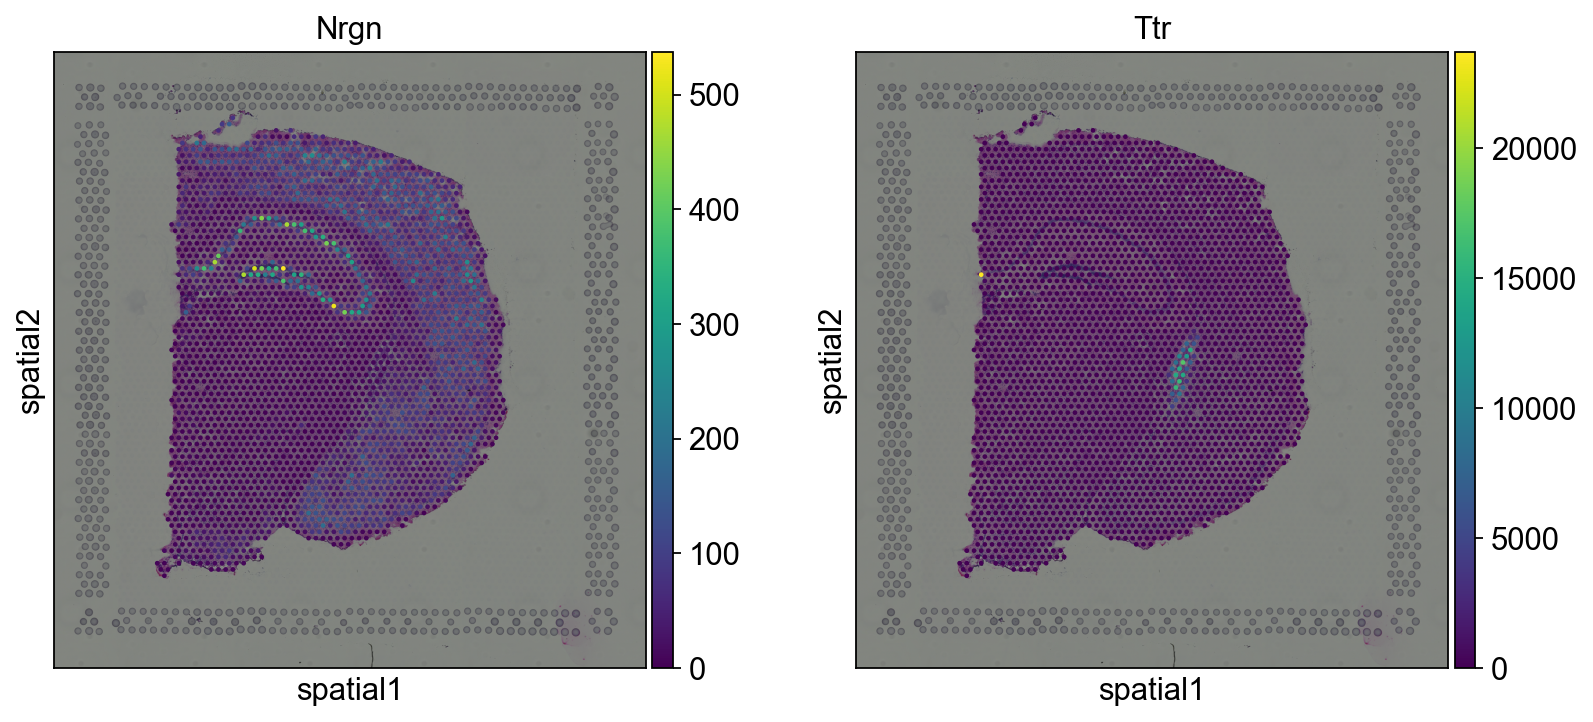

In [23]:
sq.pl.spatial_scatter(visium, color=["Nrgn", "Ttr"])

We can see that both of these genes seem to show a distinct localization in the tissue. It should be noted that they might (or might not) be also marker genes for specific cell clusters. One interpretation of spatially variable genes identification is that it is an orthogonal way to perform feature selection, by selecting genes that show a variability in space (instead of, for instance, across observations, as it is usually done).